In [24]:
import numpy as np
from ripser import Rips
import ripser
from scipy.spatial import distance_matrix
import persim
from scipy.signal import find_peaks
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import warnings
import time

In [25]:
def delay_embedding(s, T, d, step):
    N = len(s)
    X = []
    for i in range(d):
        X.append(s[i*T: N-(d-1-i)*T:step])
    return X

In [96]:
largo = 1000
t = np.linspace(0, 1, largo)

sinusoidal_data1 = np.sin(2 * np.pi * 24 * t)  # Frecuencia más alta
sinusoidal_data2 = np.sin(2 * np.pi * 12 * t)    
sinusoidal_data3 = np.sin(2 * np.pi * 6 * t)    # Frecuencia más baja
join_point = int(largo/3)
joined_signal = np.concatenate((sinusoidal_data1, sinusoidal_data2, sinusoidal_data3))


In [117]:
T = 2  # time delay
D = 3  # embedding dimension
step = 1

# Calcular el embedding 
embedding = delay_embedding(joined_signal, T, D, step)

# Reducir los datos del embedding
stride = 1
embedding = np.stack([embedding[0][::stride], embedding[1][::stride], embedding[2][::stride]])
embedding = embedding.T

In [118]:
warnings.simplefilter(action='ignore')
# Iniciar el temporizador
start_time = time.time()

lista_diagramas = []

# Definir el tamaño del intervalo
tamaño_intervalo = 50

# Iterar sobre los datos
for i in range(0, len(embedding) - tamaño_intervalo + 1):
    # Seleccionar el intervalo actual
    embedding_intervalo = embedding[i:i + tamaño_intervalo]
    
    # Calcular el diagrama persistente
    diagrama = ripser.ripser(embedding_intervalo)['dgms'][1]
    # Guardar el diagrama persistente en la lista
    lista_diagramas.append(diagrama)

# Detener el temporizador
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time
print("Tiempo de ejecución:", int(execution_time), "segundos")

Tiempo de ejecución: 3 segundos


In [119]:
start_time = time.time()

# Definir el tamaño del paso
step = 1

# Calcular las distancias de bottleneck
bottleneck_distances = {}
t=0
for t in range(step, len(lista_diagramas)):
    # Comprobar si ambos diagramas persistentes están vacíos
    if lista_diagramas[t].size == 0 and lista_diagramas[t-step].size == 0:
        # Ambos diagramas están vacíos, la distancia de bottleneck es cero
        bottleneck_distance = 0
    else:
        bottleneck_distance = persim.bottleneck(lista_diagramas[t], lista_diagramas[t-step])
    
    bottleneck_distances[t] = bottleneck_distance
    
print("Longitud bottleneck_distances:",len(bottleneck_distances))

# Detener el temporizador
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time
print("Tiempo de ejecución:", int(execution_time), "segundos")

Longitud bottleneck_distances: 2946
Tiempo de ejecución: 2 segundos


In [120]:
pico = 0.01

bd_series = np.array(list(bottleneck_distances.values()))

# Interpolación
interp_function = interp1d(np.linspace(0, 1, len(bd_series)), bd_series, kind='linear')
nuevos_indices = np.linspace(0, 1, len(joined_signal))
serie_escala = interp_function(nuevos_indices)

# Encontrar picos en la serie de distancias de bottleneck
peaks, properties = find_peaks(serie_escala, prominence=pico)

# Mostrar un mensaje si no se encontraron picos
if len(peaks) == 0:
    print("No se encontraron picos en la serie de distancias de bottleneck, cambiar el valor del pico.")
else:
    print(properties)
    
# Marcar los picos en la serie de distancias
marked_series = np.copy(serie_escala)
marked_series[peaks] = serie_escala[peaks]

# Calcular la escala para la serie de tiempo
e = len(joined_signal) / len(serie_escala)
v = peaks * e
print(len(peaks),"Picos encontrados")

{'prominences': array([0.01156843, 0.01315944, 0.01517331, 0.01538553, 0.01294789,
       0.01156843, 0.01003691, 0.01156843, 0.013353  , 0.01622994,
       0.01582904, 0.01275432, 0.01156843, 0.01048065, 0.01156843,
       0.01354656, 0.01728657, 0.01627255, 0.01312114, 0.01156843,
       0.0511815 , 0.01400206, 0.07897903, 0.05660329, 0.02145187,
       0.01671012, 0.02642844, 0.04106397]), 'left_bases': array([  15,   79,   91,  185,  197,  260,  325,  354,  418,  430,  524,
        536,  599,  664,  693,  757,  769,  863,  875,  938,  961,  969,
        984,  992, 1004, 1015, 1978, 1986], dtype=int64), 'right_bases': array([  24,   87,   99,  193,  205,  269,  331,  363,  426,  438,  532,
        544,  608,  671,  702,  765,  777,  871,  883,  948,  980,  980,
        997,  997, 1010, 1021, 1986, 1995], dtype=int64)}
28 Picos encontrados


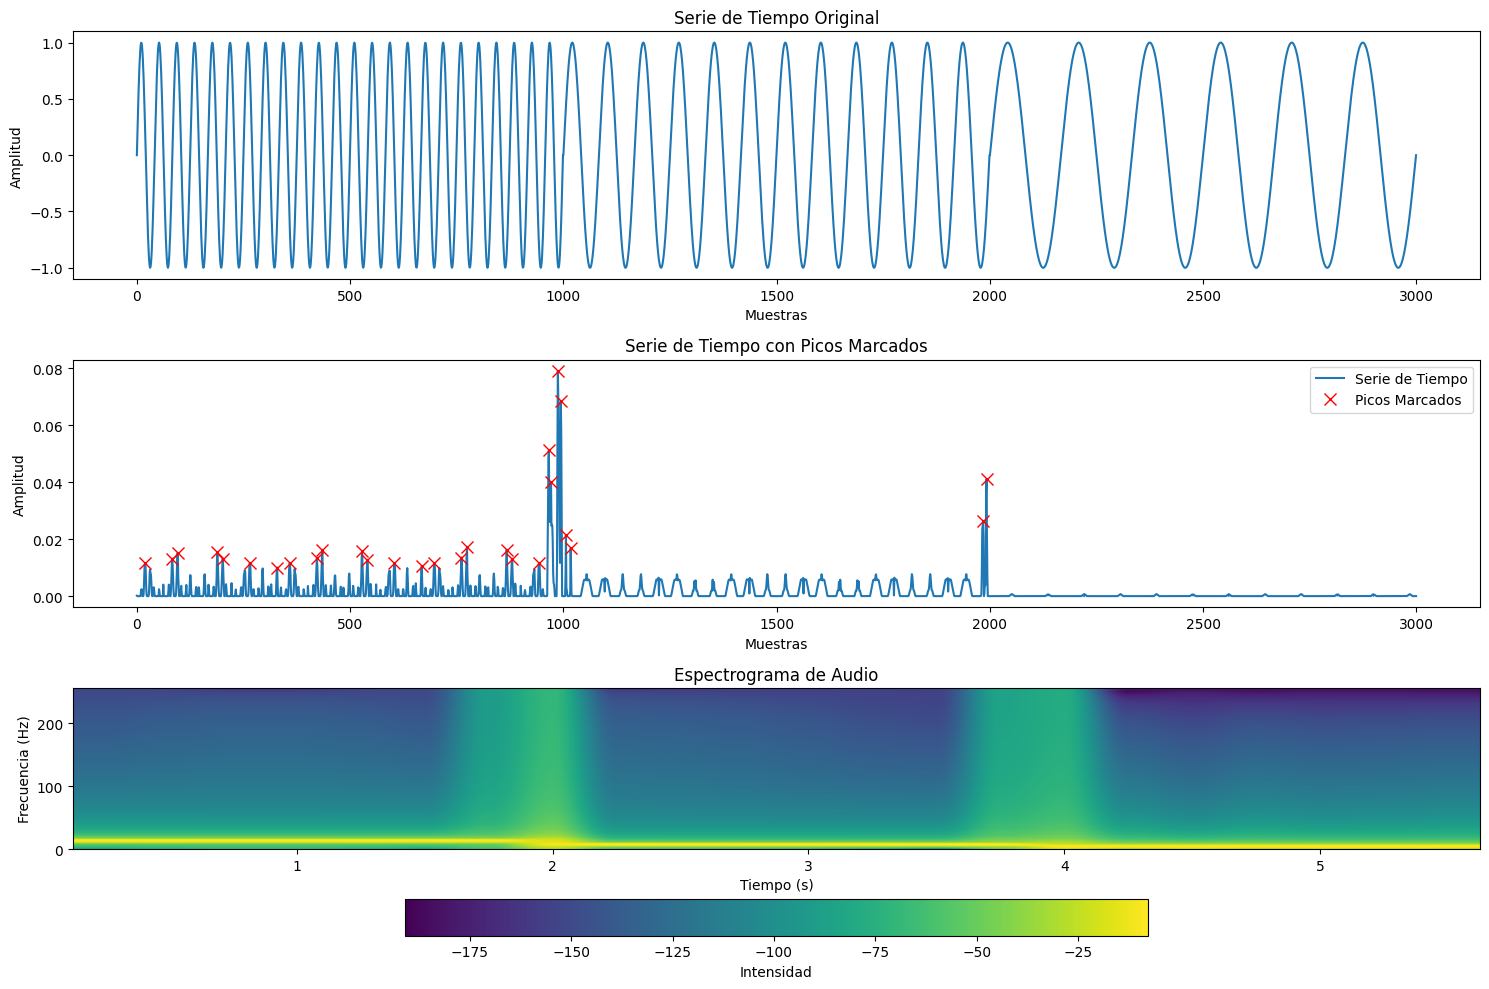

In [121]:
# Crear una nueva figura y subparcelas
plt.figure(figsize=(15, 10))

# Subparcela 1: Serie de tiempo original y serie de tiempo con picos marcados
plt.subplot(3, 1, 1)
plt.plot(joined_signal)
plt.title('Serie de Tiempo Original')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot(3, 1, 2)
plt.plot(serie_escala, label='Serie de Tiempo')
plt.plot(v, marked_series[peaks], 'rx', label='Picos Marcados', markersize=8)
plt.legend()
plt.title('Serie de Tiempo con Picos Marcados')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

# Subparcela 3: Espectrograma del audio
plt.subplot(3, 1, 3)
spec = plt.specgram(joined_signal, Fs=512)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Espectrograma de Audio')

# Crear una barra de intensidad debajo del espectrograma
cbar = plt.colorbar(spec[3], ax=plt.gca(), orientation='horizontal', pad=0.2, label='Intensidad')

# Ajustar el espaciado entre subparcelas
plt.tight_layout()

# Mostrar el gráfico
plt.show()